# Setup



## Setup - Environment, Libs



In [1]:
!pip install pandas tldextract faker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from collections import defaultdict
from os import path

import csv
from faker import Faker
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import pprint
import random
import tldextract


## Setup - Data Import

In [3]:
#!wget https://downloads.majestic.com/majestic_million.csv
#!cp "./majestic_million.csv" "./drive/MyDrive/Colab Notebooks/majestic_million.csv"
!cp "./drive/MyDrive/Colab Notebooks/majestic_million.csv" "./majestic_million.csv"
!head ./majestic_million.csv

GlobalRank,TldRank,Domain,TLD,RefSubNets,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs
1,1,google.com,com,508582,2675422,google.com,com,1,1,507741,2676763
2,2,facebook.com,com,505427,2811551,facebook.com,com,2,2,504642,2811715
3,3,youtube.com,com,458551,2303712,youtube.com,com,3,3,457730,2304157
4,4,twitter.com,com,449204,2271283,twitter.com,com,4,4,448459,2271362
5,5,instagram.com,com,379100,1840807,instagram.com,com,5,5,378564,1840327
6,6,linkedin.com,com,357638,1549319,linkedin.com,com,6,6,357250,1549123
7,7,apple.com,com,297824,1020790,apple.com,com,7,7,297230,1021404
8,8,microsoft.com,com,296900,919840,microsoft.com,com,8,8,296726,920861
9,1,wikipedia.org,org,286259,1077787,wikipedia.org,org,9,1,285780,1078195


In [4]:
!cp "./drive/MyDrive/Colab Notebooks/majestic_million_aug.csv" "./majestic_million_aug.csv"
!head ./majestic_million_aug.csv

GlobalRank,TldRank,Domain,TLD,RefSubNets,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs,domain_only,dga_score
1,1,google.com,com,508582,2675422,google.com,com,1,1,507741,2676763,google,0.198811161802689
2,2,facebook.com,com,505427,2811551,facebook.com,com,2,2,504642,2811715,facebook,0.1786731565680077
3,3,youtube.com,com,458551,2303712,youtube.com,com,3,3,457730,2304157,youtube,0.1617966543558548
4,4,twitter.com,com,449204,2271283,twitter.com,com,4,4,448459,2271362,twitter,0.3645277636967838
5,5,instagram.com,com,379100,1840807,instagram.com,com,5,5,378564,1840327,instagram,0.432577938301108
6,6,linkedin.com,com,357638,1549319,linkedin.com,com,6,6,357250,1549123,linkedin,0.4737153823076048
7,7,apple.com,com,297824,1020790,apple.com,com,7,7,297230,1021404,apple,0.2100351220218698
8,8,microsoft.com,com,296900,919840,microsoft.com,com,8,8,296726,920861,microsoft,0.2125779986482245
9,1,wikipedia.org,org,286259,1077787,wikipedia.org,org,9,1,285780,1078195,wik

In [5]:
#!wget https://data.netlab.360.com/feeds/dga/emotet.txt
#!cp "./emotet.txt" "./drive/MyDrive/Colab Notebooks/emotet.txt"
!cp "./drive/MyDrive/Colab Notebooks/emotet.txt" "./emotet.txt"
!head ./emotet.txt -n 20

# Feed of emotet domains
# The list contains three columns:
# 	Domian, Start and end of valid time(UTC)
#
# Feed Provided By: netlab 360
# netlab@360.cn
#
# Mirai scanner daily statstics and bot IP check
#    data.netlab.360.com/mirai-scanner
# DGA domain data feed
#    data.netlab.360.com/dga
# Exploit Kit data feed
#    data.netlab.360.com/ek
# All data provided by netlab@360.cn
#    data.netlab.360.com
# About Network Security Research Lab at 360
#    netlab.360.com

ieyccdyjqmlcudms.eu	2022-02-24 00:00:00	2030-01-01 00:00:00
ilrxaqlbobarnvtf.eu	2022-02-24 00:15:00	2030-01-01 00:00:00


In [6]:
#!cp "./central_leeds.png" "./drive/MyDrive/Colab Notebooks/central_leeds.png"
!cp "./drive/MyDrive/Colab Notebooks/central_leeds.png" "./central_leeds.png"

#!cp "./location_icon_r.png" "./drive/MyDrive/Colab Notebooks/location_icon_r.png"
!cp "./drive/MyDrive/Colab Notebooks/location_icon_r.png" "./location_icon_r.png"

#!cp "./location_icon_b.png" "./drive/MyDrive/Colab Notebooks/location_icon_b.png"
!cp "./drive/MyDrive/Colab Notebooks/location_icon_b.png" "./location_icon_b.png"


In [7]:
#!cp "./sample_1.csv" "./drive/MyDrive/Colab Notebooks/sample_1.csv"
!cp "./drive/MyDrive/Colab Notebooks/sample_1.csv" "./sample_1.csv"

# Obfuscation for Good

## Keep or Remove Entirely

In [8]:
# Common utility functions for non-obfuscated fields
def util_passthrough(x):
    return x

def util_overwrite(x):
    return "---"

## Create consistent fake data to retain structure

In [9]:
def obfuscate_rows(rows, obfuscator_map):
    # Iterate over the rows from the file and yield anonymized rows.
    for in_row in rows:
        out_row = {}

        for (fieldname, obf_method) in obfuscator_map.items():
            if callable(obf_method):
                out_row[fieldname] = obf_method(in_row[fieldname])
            else:   # isinstance(obf_method, defaultdict) TODO: Add exception for other types
                out_row[fieldname] = obf_method[in_row[fieldname]]

        # Yield the row back to the caller
        yield out_row


In [10]:
def obfuscate_csv(source_file, target_file, obfuscator_map):
    """
    The source argument is a path to a CSV file containing data to anonymize,
    while target is a path to write the anonymized CSV data to.
    """
    with open(source_file, 'r', encoding='utf-8-sig') as f:
        with open(target_file, 'w') as o:
            reader = csv.DictReader(f)
            writer = csv.DictWriter(o, obfuscator_map.keys()) # Obfuscation map provides output CSV headers

            # Read and anonymize data, writing to target file.
            writer.writeheader()
            for row in obfuscate_rows(reader, obfuscator_map):
                writer.writerow(row)


## Demonstrate fake data generation

In [11]:
def generate_random(obfuscator_map, count):
    fake_values = []

    for _ in range(0, count):
        row = {}

        for (fieldname, obf_method) in obfuscator_map.items():
            if callable(obf_method):
                row[fieldname] = obf_method(random.randint(0, 9999))
            else:   # isinstance(obf_method, defaultdict)
                row[fieldname] = obf_method[random.randint(0, 9999)]

        fake_values.append(row)

    return fake_values


In [12]:
def run_test_generate():
    # Load localised faker
    faker = Faker('en_GB')

    # Define outside of the dict below as we want values to be shared by more than 1 field
    internal_IPs = defaultdict(faker.ipv4_private)

    # Create mappings of names, emails, social security numbers, and phone numbers to faked names & emails
    # using provided default factory when no entry already exists
    # Dict mapping means that the same values stored and only generated if not previously seen so consistently replaced
    sample_field_obfuscators = {'time': util_passthrough,
                                'name': defaultdict(faker.name),
                                'email': defaultdict(faker.email),
                                'nino': defaultdict(faker.ssn),
                                'phone': defaultdict(faker.phone_number),
                                'dst_ip': defaultdict(faker.ipv4_public),
                                'src_ip_1': internal_IPs,
                                'src_ip_2': internal_IPs,
                                'note': util_overwrite,
                                }

    rand_data = generate_random(sample_field_obfuscators, 2)   # List of dicts (identical keys)

    print("Randomly Generated:")
    pprint.pprint(rand_data)
    print("\n")

    return rand_data

In [13]:
t = run_test_generate()


Randomly Generated:
[{'dst_ip': '205.191.229.166',
  'email': 'glenwilliams@example.com',
  'name': 'Megan Harris-Pugh',
  'nino': 'ZZ853082T',
  'note': '---',
  'phone': '+44118 4960596',
  'src_ip_1': '192.168.46.202',
  'src_ip_2': '192.168.251.54',
  'time': 2113},
 {'dst_ip': '76.69.104.77',
  'email': 'jemmareynolds@example.net',
  'name': 'Marc Lawrence',
  'nino': 'ZZ 39 34 98 T',
  'note': '---',
  'phone': '+443069990275',
  'src_ip_1': '10.140.57.79',
  'src_ip_2': '172.28.193.82',
  'time': 2155}]




In [14]:
t_df = pd.DataFrame(t)
t_df

,time,name,email,nino,phone,dst_ip,src_ip_1,src_ip_2,note
0,2113,Megan Harris-Pugh,glenwilliams@example.com,ZZ853082T,+44118 4960596,205.191.229.166,192.168.46.202,192.168.251.54,---
1,2155,Marc Lawrence,jemmareynolds@example.net,ZZ 39 34 98 T,+443069990275,76.69.104.77,10.140.57.79,172.28.193.82,---


## Obfuscate an example data set

In [15]:
def run_test_csv():

    input_csv_file = "sample_1.csv"
    output_csv_file = "sample_1_out.csv"

    print("Input CSV: " + input_csv_file + "\n")
    df_in = pd.read_csv(input_csv_file)                 # Pandas for PrettyPrint / format check
    print(df_in)

    # Load localised faker
    faker = Faker('en_GB')

    csv_field_obfuscators = {# 'Title' Will be dropped from output entirely as it is not listed as a field here
                             'First': defaultdict(faker.first_name),
                             'Last': defaultdict(faker.last_name),
                             # 'Gender' Will be dropped from output entirely as it is not listed as a field here
                             # 'PIN' Will be dropped from output entirely as it is not listed as a field here
                             'Darkest Secret': util_overwrite,
                             'Favourite Colour': defaultdict(faker.color_name),
                             'Phone No': defaultdict(faker.phone_number),
                             'Email': defaultdict(faker.email),
                             'IP Address': defaultdict(faker.ipv4_private),
                             'Commonalities': util_passthrough,
                             }

    # Run input through obfuscation, write to output file
    obfuscate_csv(input_csv_file, output_csv_file, csv_field_obfuscators)

    print("\n")
    print("Output CSV: " + output_csv_file)
    df_out = pd.read_csv(output_csv_file)
    print(df_out)


In [16]:
run_test_csv()


Input CSV: sample_1.csv

     Title      First      Last Gender   PIN      Darkest Secret  \
0     Miss      Agnes  Scarlett      F     0            Murderer   
1      Rev   Benedict     Green      M  2580             Atheist   
2  Colonel    Charles   Mustard      M  1234      Scared of fish   
3     Prof     Donald      Plum      M  3690  Easts apples whole   
4      Mrs  Elizabeth     White      F  1470     Likes fast food   
5       Dr  Frederick     Black      M  1111            Deceased   
6       Dr  Frederick     Black      M  1111            Deceased   

  Favourite Colour      Phone No           Email    IP Address Commonalities  
0              Red  01234 567890  as@example.com    10.0.0.122             A  
1            Green   01234 00001  bg@example.com  192.168.0.45             B  
2           Yellow    1235 00001  cm@example.com  192.168.0.45             B  
3           Purple    1236 00001  dp@example.com  192.168.0.50           NaN  
4            White    1237 00001  e

In [17]:
sample_in_df = pd.read_csv("sample_1.csv")
sample_in_df

,Title,First,Last,Gender,PIN,Darkest Secret,Favourite Colour,Phone No,Email,IP Address,Commonalities
0,Miss,Agnes,Scarlett,F,0,Murderer,Red,01234 567890,as@example.com,10.0.0.122,A
1,Rev,Benedict,Green,M,2580,Atheist,Green,01234 00001,bg@example.com,192.168.0.45,B
2,Colonel,Charles,Mustard,M,1234,Scared of fish,Yellow,1235 00001,cm@example.com,192.168.0.45,B
3,Prof,Donald,Plum,M,3690,Easts apples whole,Purple,1236 00001,dp@example.com,192.168.0.50,NaN
4,Mrs,Elizabeth,White,F,1470,Likes fast food,White,1237 00001,ew@example.com,10.0.0.89,NaN
5,Dr,Frederick,Black,M,1111,Deceased,Black,01234 567890,fb@example.com,192.168.0.57,A
6,Dr,Frederick,Black,M,1111,Deceased,Black,01234 567890,fb@example.com,192.168.0.57,Duplicate


In [18]:
sample_out_df = pd.read_csv("sample_1_out.csv")
sample_out_df

,First,Last,Darkest Secret,Favourite Colour,Phone No,Email,IP Address,Commonalities
0,Rosemary,Leach,---,LimeGreen,(0114) 496 0530,marcdean@example.com,10.47.102.82,A
1,June,Kelly,---,FireBrick,+44(0)114 496 0426,gerard22@example.org,10.141.236.228,B
2,Alison,Walsh,---,DarkCyan,(0115) 496 0693,begumcolin@example.net,10.141.236.228,B
3,Kathryn,Ford,---,OliveDrab,0292018050,gjones@example.net,10.255.28.210,NaN
4,Danielle,Nolan,---,LimeGreen,+44808 157 0173,seandonnelly@example.net,192.168.89.40,NaN
5,Maurice,Fitzgerald,---,Chocolate,(0114) 496 0530,john02@example.org,172.16.99.167,A
6,Maurice,Fitzgerald,---,Chocolate,(0114) 496 0530,john02@example.org,172.16.99.167,Duplicate


## Obfuscation done poorly

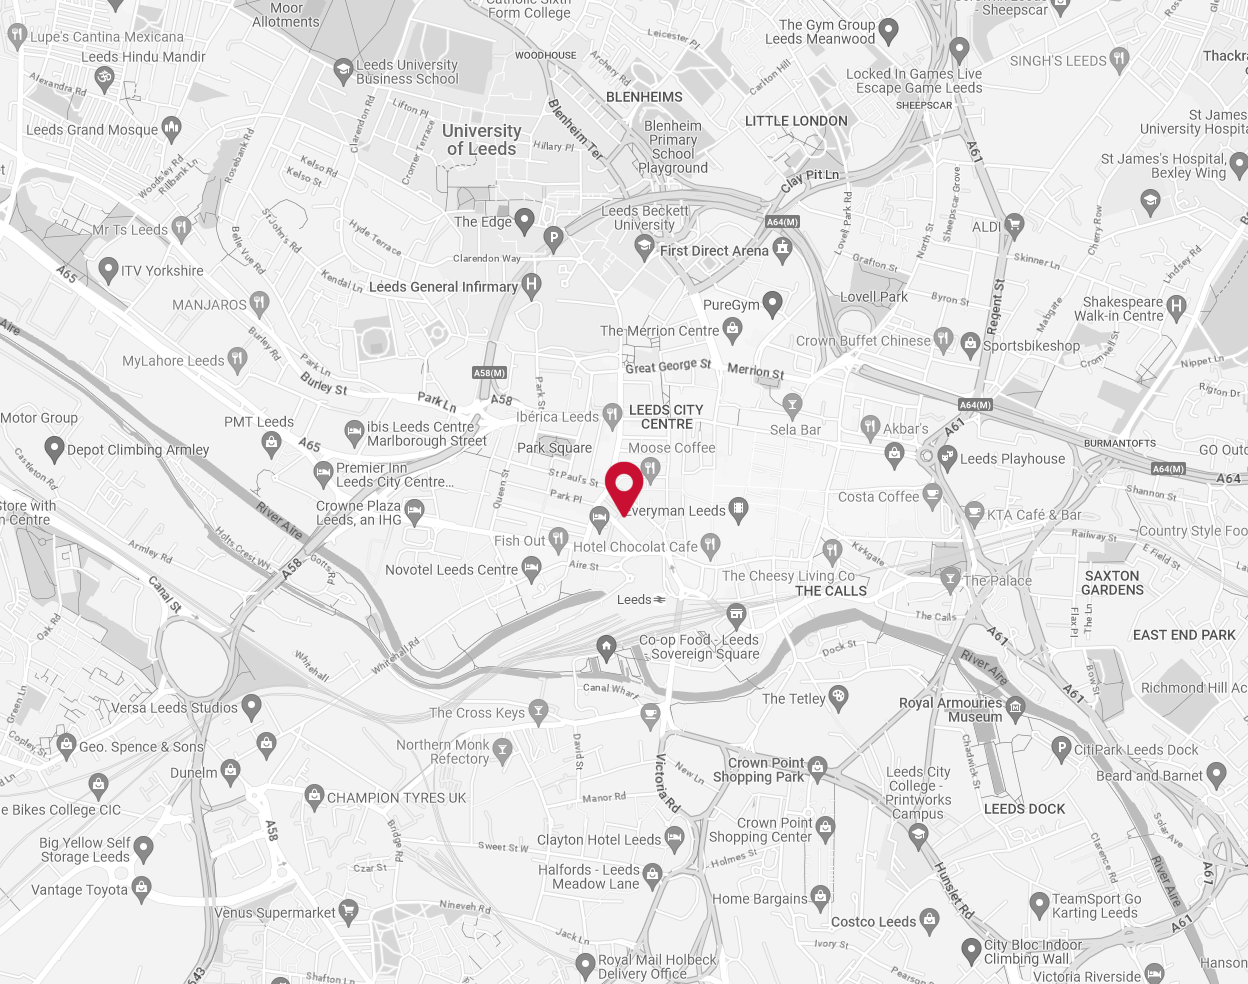

In [19]:
import glob
import random
from PIL import Image, ImageOps


img_map = Image.open('./central_leeds.png')
img_map = ImageOps.grayscale(img_map)
img_map = img_map.convert('RGB')


img_marker_r = Image.open('./location_icon_r.png').convert('RGBA')
img_marker_b = Image.open('./location_icon_b.png').convert('RGBA')
midpoint = (int(img_map.width/2 - img_marker_r.width/2), int(img_map.height/2 - img_marker_r.height/2))

img_real = img_map
img_real.paste(img_marker_r, box=midpoint, mask=img_marker_r)
img_real


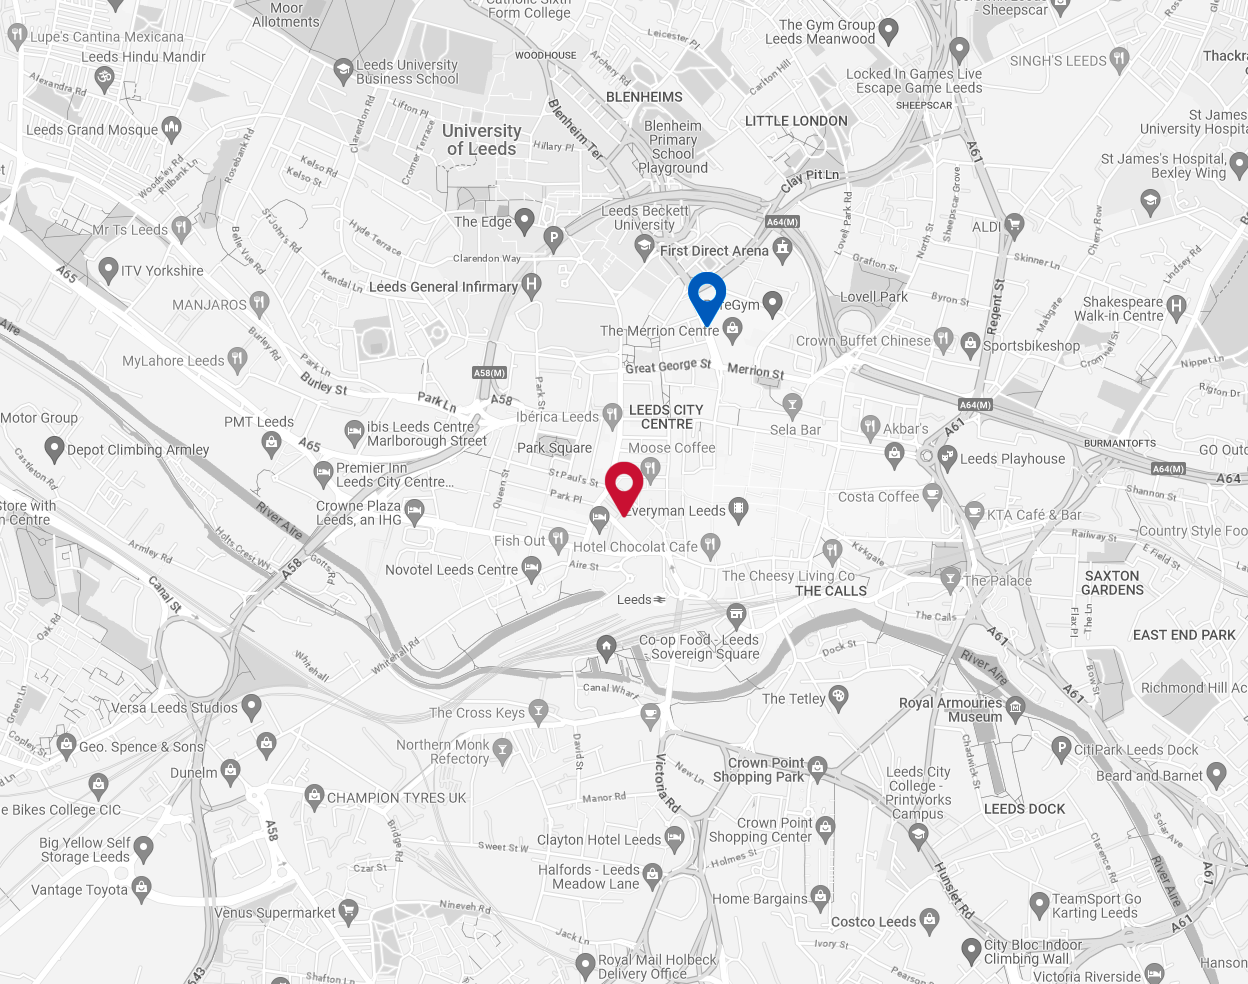

In [20]:
img_obf = img_map.copy()
obf_variance = 400

obf_loc = (midpoint[0] + random.randint(0, obf_variance) - int(obf_variance/2), midpoint[1] + random.randint(0, obf_variance) - int(obf_variance/2))
img_obf.paste(img_marker_b, box=obf_loc, mask=img_marker_b)
img_obf

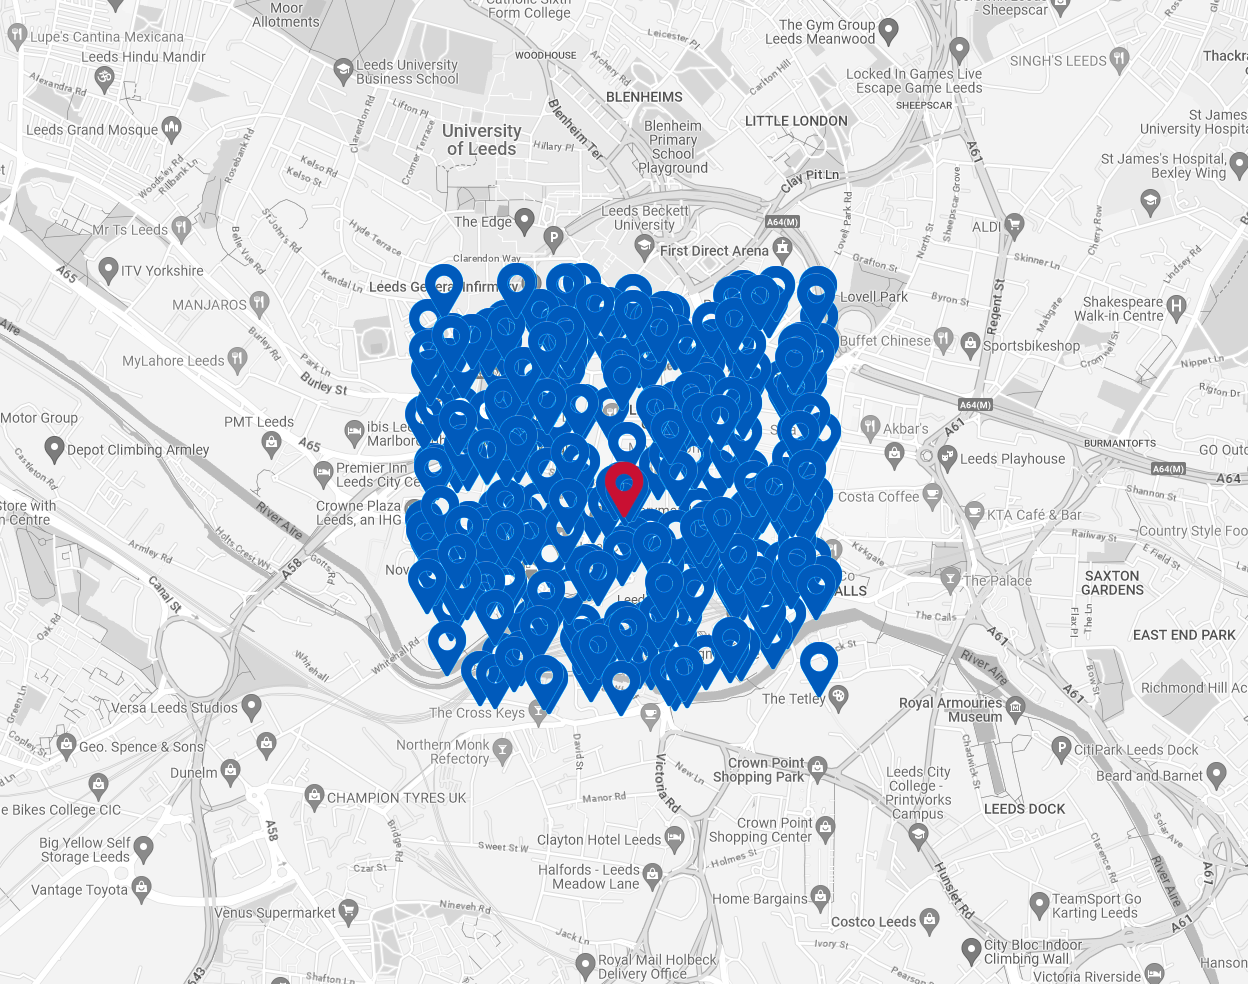

In [21]:
img_obf_agg = img_map.copy()

for i in range(0, 300):
  obf_loc = (midpoint[0] + random.randint(0, obf_variance) - int(obf_variance/2), midpoint[1] + random.randint(0, obf_variance) - int(obf_variance/2))
  img_obf_agg.paste(img_marker_b, box=obf_loc, mask=img_marker_b)


img_obf_agg.paste(img_marker_r, box=midpoint, mask=img_marker_r)
img_obf_agg

# Obfuscation for Bad

## Baseline - Top 1M Domains

## Collecting Bigrams in Top 1M Domains

---



In [22]:
mm_df = pd.read_csv('majestic_million.csv')
mm_df.head()

,GlobalRank,TldRank,Domain,TLD,RefSubNets,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs
0,1,1,google.com,com,508582,2675422,google.com,com,1,1,507741,2676763
1,2,2,facebook.com,com,505427,2811551,facebook.com,com,2,2,504642,2811715
2,3,3,youtube.com,com,458551,2303712,youtube.com,com,3,3,457730,2304157
3,4,4,twitter.com,com,449204,2271283,twitter.com,com,4,4,448459,2271362
4,5,5,instagram.com,com,379100,1840807,instagram.com,com,5,5,378564,1840327


In [23]:
mm_df['domain_only'] = mm_df['Domain'].apply(lambda x: tldextract.extract(x).domain)
mm_df[['Domain','domain_only']].head()

,Domain,domain_only
0,google.com,google
1,facebook.com,facebook
2,youtube.com,youtube
3,twitter.com,twitter
4,instagram.com,instagram


In [24]:
bigrams = defaultdict(lambda: 0)

for dom in mm_df['domain_only']:
  for i in range(0, len(dom)-1):
    bi = dom[i:i+2].upper()
    bigrams[bi] = bigrams[bi] + 1

bigrams = pd.DataFrame(bigrams.items(), columns = ('bigram', 'count'))
bigrams['normalised_count'] = bigrams['count'] / bigrams['count'].max()
bigrams.head()

,bigram,count,normalised_count
0,GO,20957,0.126469
1,OO,35833,0.216241
2,OG,19740,0.119124
3,GL,10633,0.064167
4,LE,77560,0.468049


In [25]:
bigrams.sort_values('normalised_count')

,bigram,count,normalised_count
799,6Z,12,0.000072
1368,9Q,13,0.000078
1279,0Q,16,0.000097
1317,6Q,16,0.000097
1119,9U,18,0.000109
...,...,...,...
57,RE,112706,0.680144
87,ON,114635,0.691785
63,AN,132438,0.799220
22,ER,157994,0.953442


In [26]:
bigrams[bigrams['bigram'] == 'GO']


,bigram,count,normalised_count
0,GO,20957,0.126469


## Baseline - DGA scoring via bigram commonality

In [27]:
def dga_score(domain: str) -> float:

  dom = tldextract.extract(domain).domain.upper()

  if len(dom) < 2:
    return 0

  sum = 0

  for i in range(0, len(dom)-1):
    bi = dom[i:i+2]
    score = bigrams[bigrams['bigram'] == bi]['normalised_count'].values
    if len(score) == 1:
      sum += score[0]
      #print(f'{bi}: {score}')

    # Bigrams that don't exist in the sample data will therefore have zero added, lowering normalised score

  # Normalise per number of bigrams
  n_sum = sum / (len(dom) - 1)

  #print(f'Normalised score: {n_sum}')
  return n_sum


In [28]:
print(dga_score('www.google.com'))


0.19880996204189275


In [29]:
print(dga_score('www.google.com'))
print(dga_score('www.bsidesleeds.co.uk'))
print(dga_score('bsidesleedsbsidesleedsbsidesleedsbsidesleeds.co.uk'))

print(dga_score('iuqerfsodp9ifjaposdfjhgosurijfaewrwergwea.com'))

0.19880996204189275
0.2682250209704965
0.2529442548979459
0.13726698610214294


In [30]:
dga_prescored = path.exists('./majestic_million_aug.csv')

if dga_prescored:
  mm_df = pd.read_csv('majestic_million_aug.csv')
  mm_dga_scores = mm_df['dga_score']
else:
  mm_dga_scores = mm_df['Domain'].apply(lambda x: dga_score(x))

In [31]:
mm_dga_scores.head()

0    0.198811
1    0.178673
2    0.161797
3    0.364528
4    0.432578
Name: dga_score, dtype: float64

In [32]:
mm_df[['Domain','dga_score']].head()

,Domain,dga_score
0,google.com,0.198811
1,facebook.com,0.178673
2,youtube.com,0.161797
3,twitter.com,0.364528
4,instagram.com,0.432578


In [33]:
if not dga_prescored:
  mm_df['dga_score'] = mm_dga_scores
  mm_df.to_csv('majestic_million_aug.csv')

In [34]:
!cp "./majestic_million_aug.csv" "./drive/MyDrive/Colab Notebooks/majestic_million_aug.csv"

In [35]:
mm_df.to_csv('majestic_million_aug.csv', index = False)

In [36]:
!head majestic_million_aug.csv

GlobalRank,TldRank,Domain,TLD,RefSubNets,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs,domain_only,dga_score
1,1,google.com,com,508582,2675422,google.com,com,1,1,507741,2676763,google,0.198811161802689
2,2,facebook.com,com,505427,2811551,facebook.com,com,2,2,504642,2811715,facebook,0.1786731565680077
3,3,youtube.com,com,458551,2303712,youtube.com,com,3,3,457730,2304157,youtube,0.1617966543558548
4,4,twitter.com,com,449204,2271283,twitter.com,com,4,4,448459,2271362,twitter,0.3645277636967838
5,5,instagram.com,com,379100,1840807,instagram.com,com,5,5,378564,1840327,instagram,0.432577938301108
6,6,linkedin.com,com,357638,1549319,linkedin.com,com,6,6,357250,1549123,linkedin,0.4737153823076048
7,7,apple.com,com,297824,1020790,apple.com,com,7,7,297230,1021404,apple,0.2100351220218698
8,8,microsoft.com,com,296900,919840,microsoft.com,com,8,8,296726,920861,microsoft,0.2125779986482245
9,1,wikipedia.org,org,286259,1077787,wikipedia.org,org,9,1,285780,1078195,wik

## Emotet Domains Sample

In [37]:
#!wget https://data.netlab.360.com/feeds/dga/emotet.txt
!head ./emotet.txt -n 20

# Feed of emotet domains
# The list contains three columns:
# 	Domian, Start and end of valid time(UTC)
#
# Feed Provided By: netlab 360
# netlab@360.cn
#
# Mirai scanner daily statstics and bot IP check
#    data.netlab.360.com/mirai-scanner
# DGA domain data feed
#    data.netlab.360.com/dga
# Exploit Kit data feed
#    data.netlab.360.com/ek
# All data provided by netlab@360.cn
#    data.netlab.360.com
# About Network Security Research Lab at 360
#    netlab.360.com

ieyccdyjqmlcudms.eu	2022-02-24 00:00:00	2030-01-01 00:00:00
ilrxaqlbobarnvtf.eu	2022-02-24 00:15:00	2030-01-01 00:00:00


In [38]:
bad_df = pd.read_csv('./emotet.txt', names=['Domain','Date_Start','Date_End'], delimiter='\t', comment='#')
bad_df

,Domain,Date_Start,Date_End
0,ieyccdyjqmlcudms.eu,2022-02-24 00:00:00,2030-01-01 00:00:00
1,ilrxaqlbobarnvtf.eu,2022-02-24 00:15:00,2030-01-01 00:00:00
2,cjtupcdnfooiidxa.eu,2022-02-24 00:30:00,2030-01-01 00:00:00
3,cqmqbddfdddxbvfa.eu,2022-02-24 00:45:00,2030-01-01 00:00:00
4,cxfmmqpjneeahoaa.eu,2022-02-24 01:00:00,2030-01-01 00:00:00
...,...,...,...
5947,xpkcweibbtbtaffk.eu,2022-03-26 22:45:00,2030-01-01 00:00:00
5948,xwdxuruflucvskmw.eu,2022-03-26 23:00:00,2030-01-01 00:00:00
5949,xejtgsuwvvdxldhw.eu,2022-03-26 23:15:00,2030-01-01 00:00:00
5950,xlcprguotkrarvoj.eu,2022-03-26 23:30:00,2030-01-01 00:00:00


In [39]:
bad_df['domain_only'] = bad_df['Domain'].apply(lambda x: tldextract.extract(x).domain)
bad_df

,Domain,Date_Start,Date_End,domain_only
0,ieyccdyjqmlcudms.eu,2022-02-24 00:00:00,2030-01-01 00:00:00,ieyccdyjqmlcudms
1,ilrxaqlbobarnvtf.eu,2022-02-24 00:15:00,2030-01-01 00:00:00,ilrxaqlbobarnvtf
2,cjtupcdnfooiidxa.eu,2022-02-24 00:30:00,2030-01-01 00:00:00,cjtupcdnfooiidxa
3,cqmqbddfdddxbvfa.eu,2022-02-24 00:45:00,2030-01-01 00:00:00,cqmqbddfdddxbvfa
4,cxfmmqpjneeahoaa.eu,2022-02-24 01:00:00,2030-01-01 00:00:00,cxfmmqpjneeahoaa
...,...,...,...,...
5947,xpkcweibbtbtaffk.eu,2022-03-26 22:45:00,2030-01-01 00:00:00,xpkcweibbtbtaffk
5948,xwdxuruflucvskmw.eu,2022-03-26 23:00:00,2030-01-01 00:00:00,xwdxuruflucvskmw
5949,xejtgsuwvvdxldhw.eu,2022-03-26 23:15:00,2030-01-01 00:00:00,xejtgsuwvvdxldhw
5950,xlcprguotkrarvoj.eu,2022-03-26 23:30:00,2030-01-01 00:00:00,xlcprguotkrarvoj


In [40]:
bad_scores = bad_df['domain_only'].apply(lambda x: dga_score(x))
bad_scores

0       0.051798
1       0.113905
2       0.069904
3       0.019221
4       0.111453
          ...   
5947    0.068290
5948    0.053886
5949    0.029277
5950    0.134982
5951    0.092619
Name: domain_only, Length: 5952, dtype: float64

In [41]:
bad_df['dga_score'] = bad_scores
bad_df[['Domain', 'dga_score']]

,Domain,dga_score
0,ieyccdyjqmlcudms.eu,0.051798
1,ilrxaqlbobarnvtf.eu,0.113905
2,cjtupcdnfooiidxa.eu,0.069904
3,cqmqbddfdddxbvfa.eu,0.019221
4,cxfmmqpjneeahoaa.eu,0.111453
...,...,...
5947,xpkcweibbtbtaffk.eu,0.068290
5948,xwdxuruflucvskmw.eu,0.053886
5949,xejtgsuwvvdxldhw.eu,0.029277
5950,xlcprguotkrarvoj.eu,0.134982


In [42]:
mm_df['domain_len'] = mm_df['domain_only'].astype(str).apply(lambda x: len(x))

## Contrast DGA Scores - Good vs. Bad

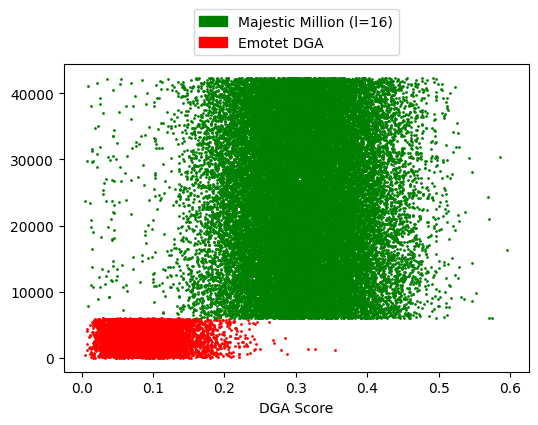

In [43]:
fig, ax = plt.subplots(figsize=(6,4), dpi=100)

green_patch = mpatches.Patch(color='g', label='Majestic Million (l=16)')
red_patch = mpatches.Patch(color='r', label='Emotet DGA')
ax.legend(handles=[green_patch,red_patch], loc='upper center', bbox_to_anchor=(0.5, 1.2))
ax.set_xlabel('DGA Score')

x = bad_df['dga_score']
bad_count = len(bad_df)
y = range(0, bad_count)
ax.scatter(x, y, marker="o", s=1, c='r')

x = mm_df[mm_df['domain_len'] == 16]['dga_score']
good_count = len(x)
y = range(bad_count, good_count + bad_count)
ax.scatter(x, y, marker="o", s=1, c='g')

plt.show()

In [44]:
mm_df[mm_df['domain_len'] == 16]

,GlobalRank,TldRank,Domain,TLD,RefSubNets,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs,domain_only,dga_score,domain_len
10,11,9,googletagmanager.com,com,260566,914175,googletagmanager.com,com,11,9,260138,914097,googletagmanager,0.330211,16
90,91,64,youtube-nocookie.com,com,93061,243505,youtube-nocookie.com,com,90,63,92998,244036,youtube-nocookie,0.166775,16
443,444,283,medicalnewstoday.com,com,42172,94941,medicalnewstoday.com,com,450,285,41906,94873,medicalnewstoday,0.310210,16
635,636,387,technologyreview.com,com,34759,63895,technologyreview.com,com,637,386,34676,63905,technologyreview,0.242686,16
954,955,554,goodhousekeeping.com,com,27355,55092,goodhousekeeping.com,com,961,556,27148,55037,goodhousekeeping,0.251382,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999849,999850,505489,haliyikamamakine.com,com,292,1677,haliyikamamakine.com,com,-1,-1,-1,-1,haliyikamamakine,0.326210,16
999860,999861,505500,pinemillscatfish.com,com,292,1676,pinemillscatfish.com,com,983891,496674,295,1686,pinemillscatfish,0.303326,16
999880,999881,505520,percillainternet.com,com,292,1674,percillainternet.com,com,979581,494334,296,1684,percillainternet,0.439325,16
999931,999932,505571,xinshangmengwang.com,com,292,1670,xinshangmengwang.com,com,979630,494383,296,1676,xinshangmengwang,0.383629,16


In [45]:
bad_df

,Domain,Date_Start,Date_End,domain_only,dga_score
0,ieyccdyjqmlcudms.eu,2022-02-24 00:00:00,2030-01-01 00:00:00,ieyccdyjqmlcudms,0.051798
1,ilrxaqlbobarnvtf.eu,2022-02-24 00:15:00,2030-01-01 00:00:00,ilrxaqlbobarnvtf,0.113905
2,cjtupcdnfooiidxa.eu,2022-02-24 00:30:00,2030-01-01 00:00:00,cjtupcdnfooiidxa,0.069904
3,cqmqbddfdddxbvfa.eu,2022-02-24 00:45:00,2030-01-01 00:00:00,cqmqbddfdddxbvfa,0.019221
4,cxfmmqpjneeahoaa.eu,2022-02-24 01:00:00,2030-01-01 00:00:00,cxfmmqpjneeahoaa,0.111453
...,...,...,...,...,...
5947,xpkcweibbtbtaffk.eu,2022-03-26 22:45:00,2030-01-01 00:00:00,xpkcweibbtbtaffk,0.068290
5948,xwdxuruflucvskmw.eu,2022-03-26 23:00:00,2030-01-01 00:00:00,xwdxuruflucvskmw,0.053886
5949,xejtgsuwvvdxldhw.eu,2022-03-26 23:15:00,2030-01-01 00:00:00,xejtgsuwvvdxldhw,0.029277
5950,xlcprguotkrarvoj.eu,2022-03-26 23:30:00,2030-01-01 00:00:00,xlcprguotkrarvoj,0.134982


In [46]:
mm_df[mm_df['dga_score'] < 0.1]

,GlobalRank,TldRank,Domain,TLD,RefSubNets,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs,domain_only,dga_score,domain_len
34,35,28,tumblr.com,com,154817,518687,tumblr.com,com,35,28,154600,518889,tumblr,0.090947,6
42,43,34,qq.com,com,132287,827792,qq.com,com,43,34,132186,828902,qq,0.001551,2
48,49,6,w3.org,org,122394,276103,w3.org,org,49,6,122350,276246,w3,0.000869,2
53,54,1,t.co,co,119739,351785,t.co,co,54,1,119553,351752,t,0.000000,1
65,66,47,cnn.com,com,110660,288575,cnn.com,com,66,47,110544,288633,cnn,0.054062,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999987,999988,505627,ssmmyy.com,com,292,1663,ssmmyy.com,com,997558,504187,292,1665,ssmmyy,0.084340,6
999988,999989,505628,100mscmsc.com,com,292,1662,100mscmsc.com,com,997571,504200,292,1662,100mscmsc,0.073065,9
999989,999990,505629,452598.com,com,292,1662,452598.com,com,-1,-1,-1,-1,452598,0.002306,6
999992,999993,505632,172320.com,com,292,1661,172320.com,com,-1,-1,-1,-1,172320,0.007207,6
